<a href="https://colab.research.google.com/github/Shivakumarsullagaddi/CCBD_MRI/blob/main/2D_RESNET18_BC_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Binary Classification
#2D slices + ResNet18

0 → CN (Not Alzheimer's)

1 → Alzheimer's (AD, LMCI, EMCI)



---
Improved from 1st code

---



*   correct spliting data to 70% training,15% validation,15% testimg
*   Enables Fair Comparison



```
 69.66% ACC achivied
```

**Problem :** *Model unable to distinguish between the axial,sagatial,coronal*


get tha dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


import

In [12]:
import os
import random
import torch
import numpy as np
import nibabel as nib
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt


Define transformer

In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


custom dataset

In [14]:
class MRISliceDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples  # list of (nii_path, label)
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        nii_path, label = self.samples[idx]
        img = nib.load(nii_path).get_fdata()
        slice_idx = img.shape[2] // 2
        slice_img = img[:, :, slice_idx]
        slice_img = (slice_img - np.min(slice_img)) / (np.max(slice_img) - np.min(slice_img) + 1e-8)
        slice_img = (slice_img * 255).astype(np.uint8)
        pil_img = Image.fromarray(slice_img).convert('RGB')
        if self.transform:
            pil_img = self.transform(pil_img)
        return pil_img, label


prepare subject level

In [15]:
root_dir = '/content/drive/MyDrive/MRI_DATASET/nifti/nifti'
class_names = ['AD', 'CN', 'EMCI', 'LMCI']
class_map = {'CN': 0, 'AD': 1, 'EMCI': 1, 'LMCI': 1}
random.seed(42)

train_samples, val_samples, test_samples = [], [], []

for cls in class_names:
    class_dir = os.path.join(root_dir, cls)
    subjects = sorted(os.listdir(class_dir))
    random.shuffle(subjects)
    n_total = len(subjects)
    n_train = int(0.7 * n_total)
    n_val = int(0.15 * n_total)
    n_test = n_total - n_train - n_val

    train_subjs = subjects[:n_train]
    val_subjs = subjects[n_train:n_train+n_val]
    test_subjs = subjects[n_train+n_val:]

    for subj_list, sample_list in zip([train_subjs, val_subjs, test_subjs],
                                      [train_samples, val_samples, test_samples]):
        for subj in subj_list:
            subj_dir = os.path.join(class_dir, subj)
            for f in os.listdir(subj_dir):
                if f.endswith('.nii') or f.endswith('.nii.gz'):
                    sample_list.append((os.path.join(subj_dir, f), class_map[cls]))


data loaders

In [16]:
train_dataset = MRISliceDataset(train_samples, transform=transform)
val_dataset = MRISliceDataset(val_samples, transform=transform)
test_dataset = MRISliceDataset(test_samples, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


load and modify resnet

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)


Training

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(5):  # Increase epochs as needed
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    ep_tr_acc = 100 * correct / total

    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    ep_val_acc = 100 * val_correct / val_total

    duration = time.time() - start_time
    avg_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch: {epoch+1}, Time: {duration:.2f}s, Loss: {avg_loss:.4f}, "
          f"Train_acc: {ep_tr_acc:.2f}%, Val_acc: {ep_val_acc:.2f}%")


Epoch: 1, Time: 195.27s, Loss: 0.5909, Train_acc: 73.72%, Val_acc: 78.12%
Epoch: 2, Time: 181.35s, Loss: 0.2495, Train_acc: 90.06%, Val_acc: 71.88%
Epoch: 3, Time: 177.00s, Loss: 0.0759, Train_acc: 100.00%, Val_acc: 71.88%
Epoch: 4, Time: 185.71s, Loss: 0.0292, Train_acc: 100.00%, Val_acc: 73.44%
Epoch: 5, Time: 182.14s, Loss: 0.0255, Train_acc: 100.00%, Val_acc: 70.31%


Validation

In [20]:
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")


Test Accuracy: 75.00%


#For visualization

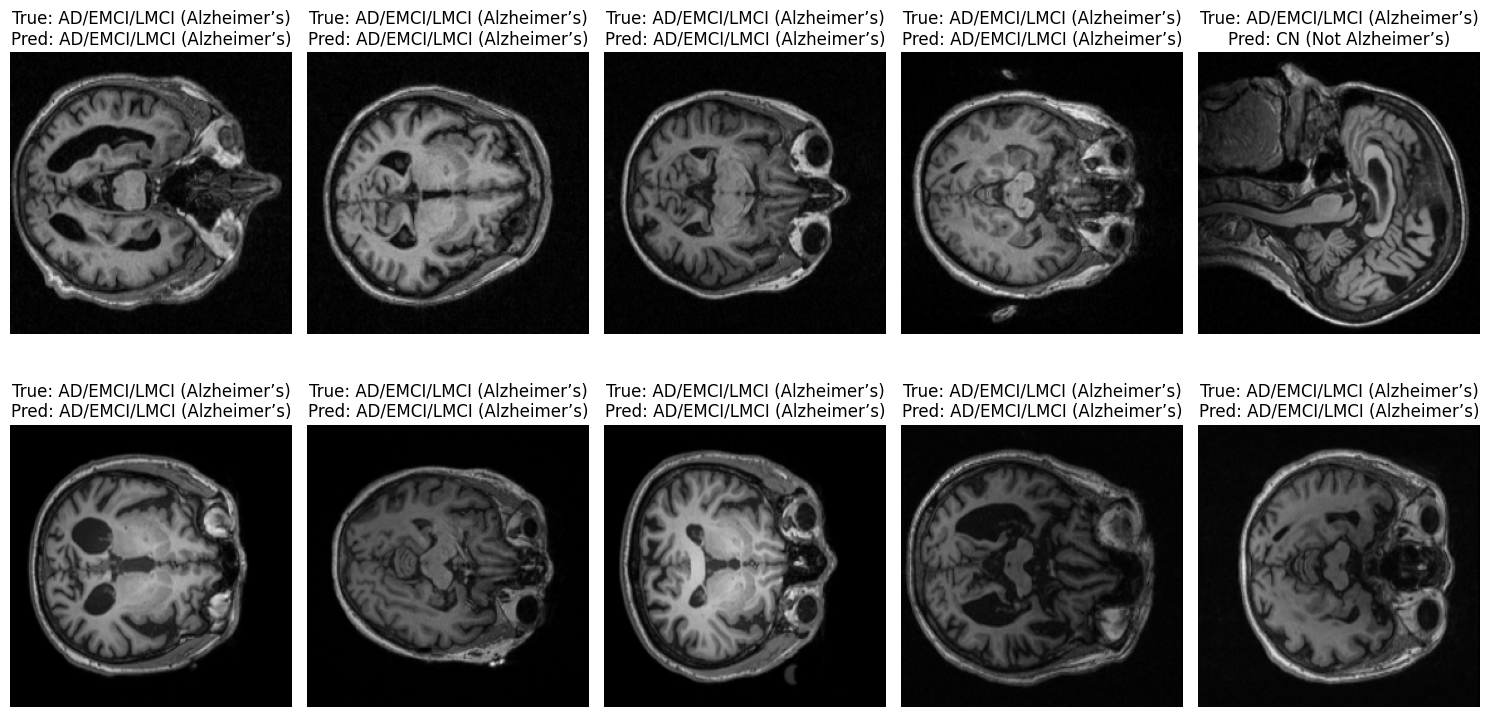

In [21]:
# Visualize a few test results
model.eval()
images_list, true_labels, pred_labels = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        for i in range(images.size(0)):
            img = images[i].cpu().numpy().transpose(1, 2, 0)
            img = (img * 0.5 + 0.5) * 255
            img = img.astype('uint8')
            images_list.append(img)
            true_labels.append(labels[i].item())
            pred_labels.append(predicted[i].cpu().item())

class_names = {0: "CN (Not Alzheimer’s)", 1: "AD/EMCI/LMCI (Alzheimer’s)"}
num_examples = 10
plt.figure(figsize=(15, 8))
for idx in range(num_examples):
    plt.subplot(2, 5, idx+1)
    plt.imshow(images_list[idx])
    plt.title(f"True: {class_names[true_labels[idx]]}\nPred: {class_names[pred_labels[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
